- MixUp Training
  - Definition
    - One of data augmentation techniques
      - Generate new pairs of data by linearly interpolating input features and albels
    - Be able to learn more generalizable decision boundaries 
  - Advantages
    - Enhanced generatlization: Generated new data is able to keep its original characteristics with various transformations -> Learn variable patterns and characteristics
    - Reduced Overfitting:
    - Increased variety of data chracteristics
    - Useful in a situation with limited amount of data
    - Easy to apply

### Import Modules

In [19]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Define a Custom Model

In [20]:
# Define a model
class MyModel(nn.Module):
    # Initialize the model
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        
    # Forward
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

### Load Dataset

In [21]:
# Set transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3))
])

print(train_transform)

Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.3, 0.3, 0.3))
)


In [22]:
# Load dataset
train_dataset = datasets.CIFAR10(root = './data/0706-CIFAR10',
                                 train = True,
                                 transform = train_transform,
                                 download = True)
train_dataloder = DataLoader(train_dataset, 
                             batch_size = 64,
                             shuffle = True)


Files already downloaded and verified


### Set a Model

In [23]:
# Set a model
model = MyModel()
print(model)

MyModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Set a Loss Function and Optimizer

In [24]:
# Set Loss Function
criterion = nn.CrossEntropyLoss()
print(criterion)

# Set Optimzier
optimizer = optim.SGD(model.parameters(), lr=0.005)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Define a MixUp Augmentation

In [25]:
# Define MixUp augmentation
def mixup_data(x, y, alpha=1.0):
    # Set a batch size for input data
    batch_size = x.size(0)
    
    
    ##### Set 'x'
    # Generate Rank4 Tensor with random lambda values between '0' and '1'
    lam = torch.rand(batch_size, 1, 1, 1)
    
    # Set lambda values between '0.0' and '0.5'
    lam = torch.max(lam, 1 - lam)
    
    # Apply mixup to input data 'x': Add lambda values to flipped 'x'
    mixed_x = lam * x + (1 - lam) * x.flip(dims = [0, 2, 3])
    
    
    ##### Set 'y'
    # Generate a random permutation of integers
    indices = torch.randperm(batch_size)
    
    # Apply mixup to input data 'y': Add lambda values to labels
    mixed_y = lam.squeeze() * y + (1 - lam.squeeze()) * y[indices]
    
    # Change data type to 'torch.long'
    mixed_y = mixed_y.type(torch.long)
    
    
    return mixed_x, mixed_y

### Define a Visualization Class

In [26]:
# Define a class for visualization
def plot_images(images, labels, title):
    fig, axes = plt.subplots(2, 5, # (2, 5): 2x5 Grid layout (Rows x Columns)
                             figsize=(12, 6))
    fig.suptitle(title, fontsize=16)
    labels = labels.numpy()
    for i, ax in enumerate(axes.flat):
        image = images[i].squeeze()   # 'squeeze()': Remove dimensions of size '1'
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
    plt.show

### Fit Models

In [27]:
# Set lists of Loss Functions
train_loss_no_mixup = []
train_loss_with_mixup = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

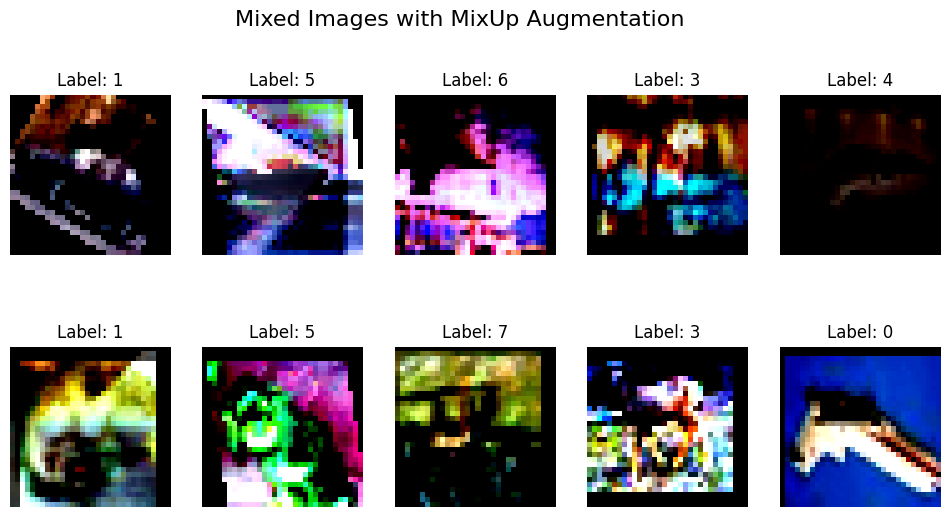

In [28]:
# Set parameters
num_epochs = 10
end_idx = 0

# Fit a model
for epoch in range(num_epochs):
    # Initialize Loss values
    train_loss_no = 0.0
    train_loss = 0.0
    
    # Fit the model
    for inputs, labels in train_dataloder:
        # Initialize optimizer
        optimizer.zero_grad()
        
        
        # Set temp values
        images_temp, labels_temp = inputs, labels
        
        # Set inputs, labels
        inputs, labels = mixup_data(inputs, labels)
        
        # Set mixed images with MixUp 
        mixed_images = inputs.cpu().numpy() # 'cpu()': Ensure tensor is on CPU before converting to NumPy
        mixed_images = np.transpose(  # 'np.transpose(A, B)': Transpose dimensions of NumPy array 'A' to desired order 'B'
            mixed_images,   # 'A': NumPy array
            (0, 2, 3, 1)    # 'B': desired orders to be transposed
        )   
        mixed_images = np.squeeze(mixed_images)
        
        
        # 'plot images': Keep track of whether images are plotted or not
        if end_idx == 0:
            plot_images(mixed_images,
                        labels.squeeze(),  # Run 'squeeze()' before pass data to 'plot_images' function
                        'Mixed Images with MixUp Augmentation')
            end_idx = 1   # Assign 'end_idx=1' when plotting images
        
        
        # Set outputs
        outputs_no_mixup = model(images_temp)
        outputs_mixup = model(inputs)
        
        
        # Set labels
        labels = torch.squeeze(labels)  # Convert labels to Rank1 Tensor
        
        
        # Set Loss Functions
        loss_no_mixup = criterion(outputs_no_mixup, labels)
        loss_mixup = criterion(outputs_mixup, labels)
        
        
        # Backpropagation
        loss_no_mixup.backward()
        loss_mixup.backward()
        
        # Update parameters for optimizer
        optimizer.step()
        
        
        # Calculate Loss values
        train_loss_no += loss_no_mixup.item()
        train_loss += loss_mixup.item()
        
    # Record Loss by each epoch
    train_loss_no_mixup.append(train_loss_no / len(train_dataloder))
    train_loss_with_mixup.append(train_loss / len(train_dataloder))

### Visualization

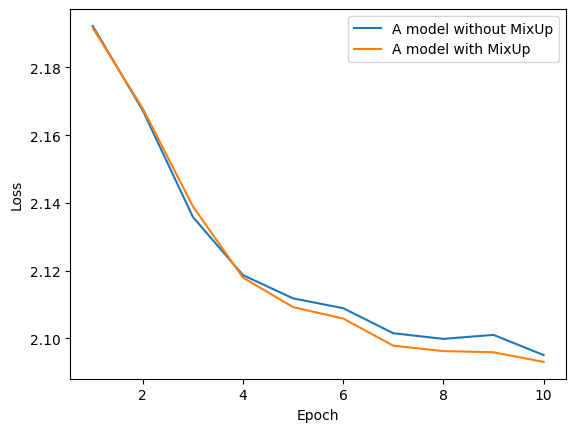

In [29]:
# Visualization
epochs = range(1, num_epochs+1)

plt.plot(epochs, train_loss_no_mixup, label='A model without MixUp')
plt.plot(epochs, train_loss_with_mixup, label='A model with MixUp')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()